# **Ф36**: Модуль генерации ценностно-ориентированных требований к трансформации территорий

## 1. Читаем подготовленные данные

In [21]:
import pandas as pd
import geopandas as gpd
from blocksnet.config import log_config

log_config.set_disable_tqdm(True)
log_config.set_logger_level('ERROR')

service_types = pd.read_pickle('./data/service_types.pickle')
blocks = pd.read_pickle('./data/blocks.pickle')
acc_mx = pd.read_pickle('./data/acc_mx.pickle')

Берем лишь те типы сервисов, где известны ценности, которые они поддерживают

In [22]:
service_types = service_types[~service_types['social_values'].isna()].copy()

## 2. Вспомогательный код и оценка

0. Обнуляем сервисы и здания в границах проекта.
1. Считаем обеспеченности по каждому типу сервиса (если столбца нет, то у нас и типа сервиса нет по идее вокруг и на территории).
2. Обрезаем до уровня контекста.
3. Считаем суммарную оценку по контексту кварталов и ассоциируем её с ценностью.

P.S: под контекстом в данном случае понимаем не контекст в рамках Простора, а контекст в рамках доступности квартала.

In [23]:
from blocksnet.relations.accessibility import get_accessibility_context

def _get_project_context(blocks : pd.DataFrame, acc_mx : pd.DataFrame, accessibility : float) -> list[int]:
  project_blocks = blocks[blocks['is_project']].copy()
  context_blocks = get_accessibility_context(acc_mx, project_blocks, accessibility, out=False, keep=False)
  return list(context_blocks.index)

In [29]:
from blocksnet.analysis.provision import competitive_provision, provision_strong_total
from blocksnet.config import service_types_config

def _assess_provision(blocks : pd.DataFrame, acc_mx : pd.DataFrame, service_type : str) -> tuple[float, gpd.GeoDataFrame]:
  _, demand, accessibility = service_types_config[service_type].values()
  capacity_column = f'capacity_{service_type}'
  if capacity_column not in blocks.columns:
    return 0.0, None
  context_ids = _get_project_context(blocks, acc_mx, accessibility)
  blocks_df = blocks.rename(columns={capacity_column:'capacity'})[['geometry', 'population', 'capacity']].fillna(0)
  blocks_df.loc[blocks['is_project'], ['population', 'capacity']] = 0
  prov_df, _ = competitive_provision(blocks_df, acc_mx, accessibility, demand)
  prov_df = prov_df.loc[context_ids].copy()
  
  if prov_df['demand'].sum() == 0:
    return None, None
  
  # # FIXME remove later
  # plot_blocks = blocks.loc[context_ids, ['geometry']].copy()
  # ax = plot_blocks.plot(color='#ddd')
  # plot_blocks.join(prov_df).plot(ax=ax, column='provision_strong', legend=True, vmin=0, vmax=1, cmap='RdYlGn')
  # ax.set_axis_off()
  # ax.set_title(service_type) 
  
  return float(provision_strong_total(prov_df)), blocks.loc[context_ids, ['geometry']].join(prov_df)

In [30]:
social_values_provisions = {}
provisions_gdfs = {}

for st_id in service_types.index:
  st_name = service_types.loc[st_id,'name']
  social_values = service_types.loc[st_id,'social_values']
  prov_total, prov_gdf = _assess_provision(blocks, acc_mx, st_name)
  provisions_gdfs[st_name] = prov_gdf
  for social_value in social_values:
    if social_value in social_values_provisions:
      social_values_provisions[social_value].append(prov_total)
    else:
      social_values_provisions[social_value] = [prov_total]

## 2. Результат

`soc_value_id` -> уровень поддержки ценности

In [31]:
import numpy as np

def _get_value_level(provisions : list[float | None]) -> float:
  provisions = [p for p in provisions if p is not None]
  return np.mean(provisions)

index = social_values_provisions.keys()
columns = ['social_value_level']
result_df = pd.DataFrame(data=[_get_value_level(social_values_provisions[sv_id]) for sv_id in index], index=index, columns=columns)
result_df

,social_value_level
8,0.746403
2,0.337037
4,0.337037
10,0.000000
17,0.333333
15,0.642689
16,0.674924
11,0.661871
3,0.985612
7,0.262405


Слои с оценкой обеспеченности в границах контекста

/home/vasilstar/prostor-examples/.venv/lib/python3.10/site-packages/geopandas/plotting.py:658: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


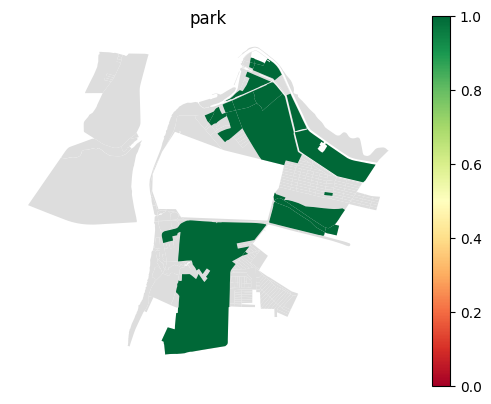

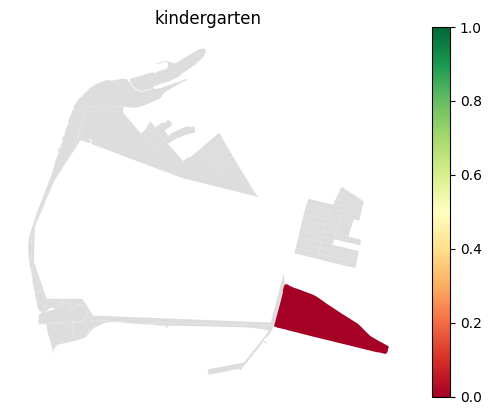

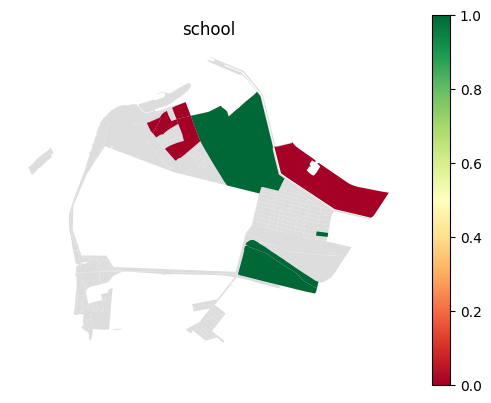

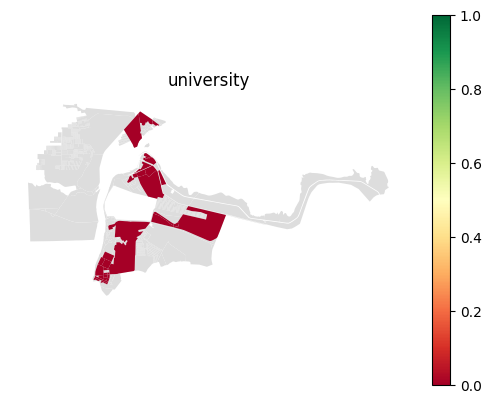

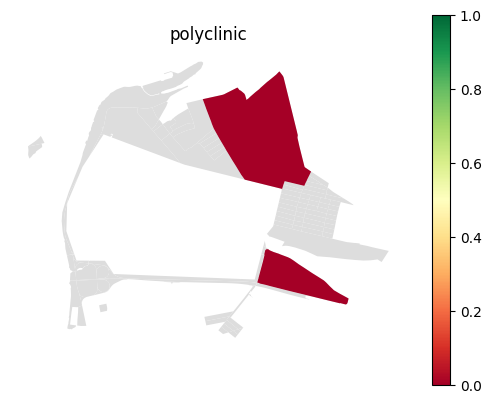

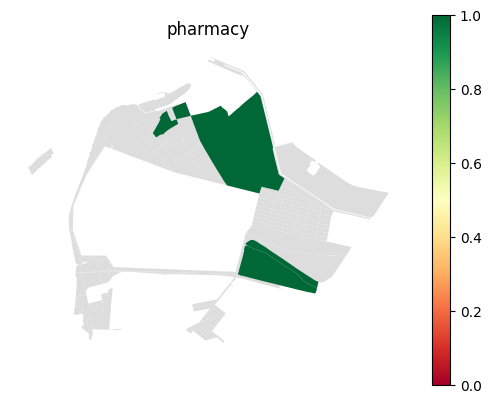

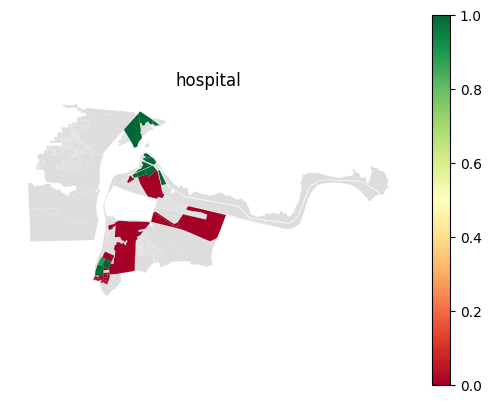

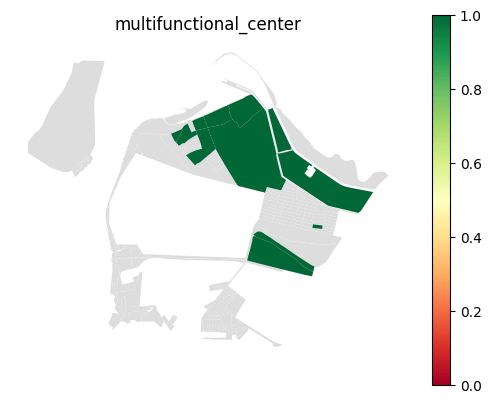

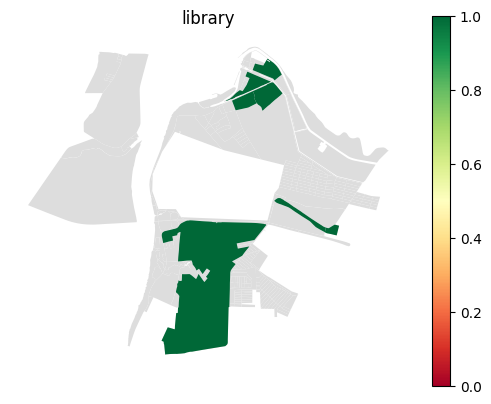

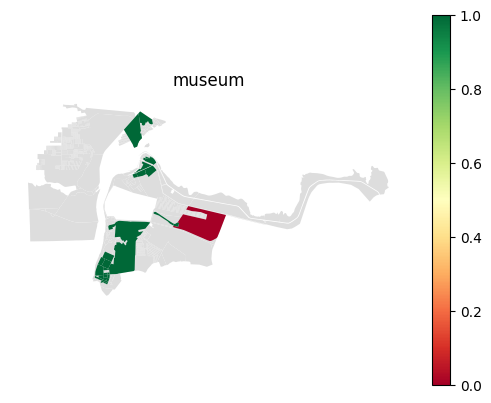

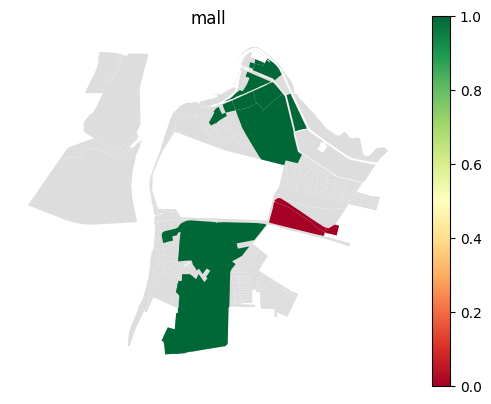

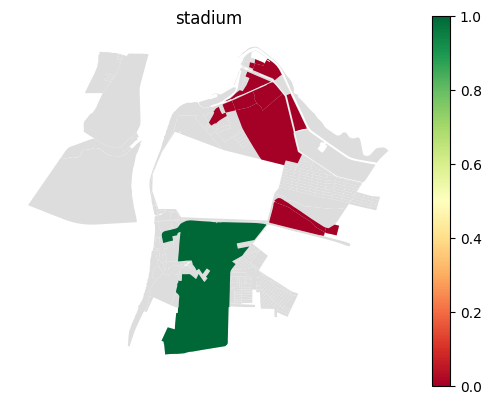

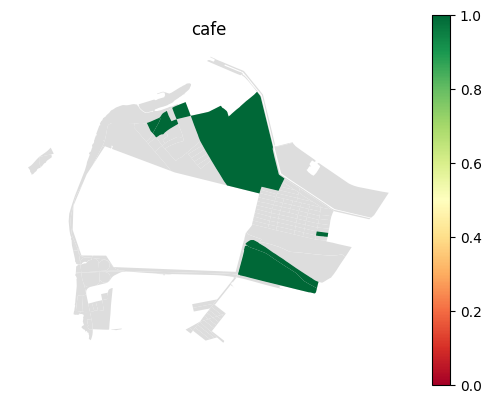

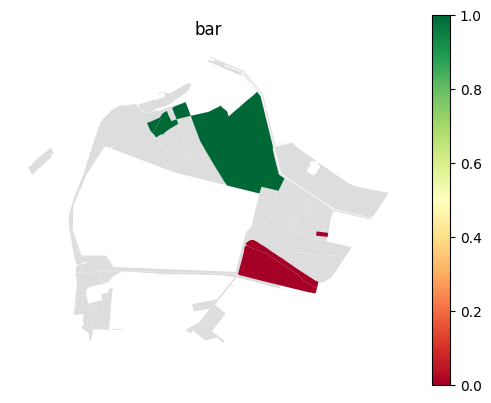

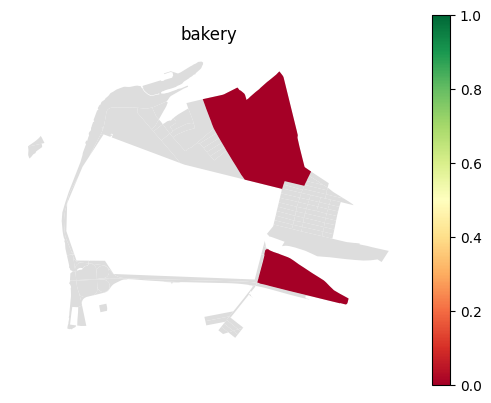

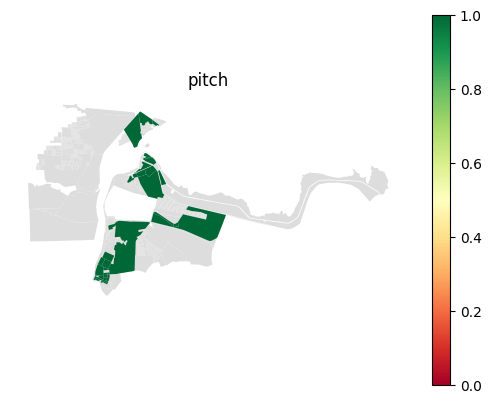

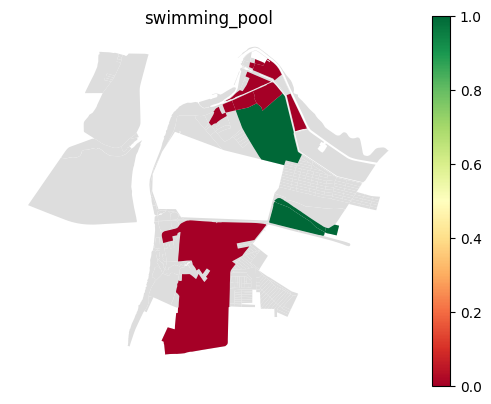

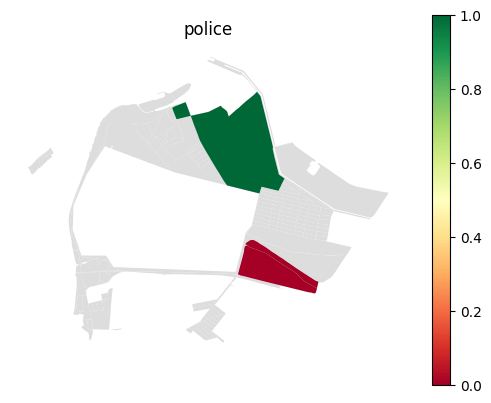

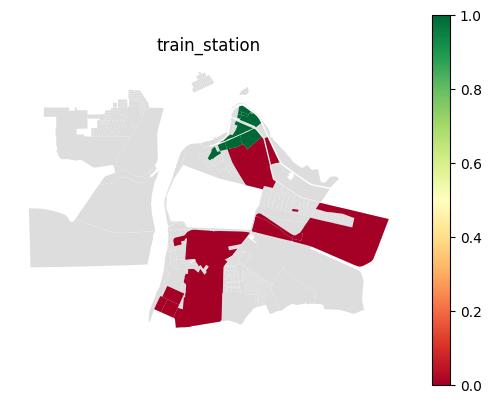

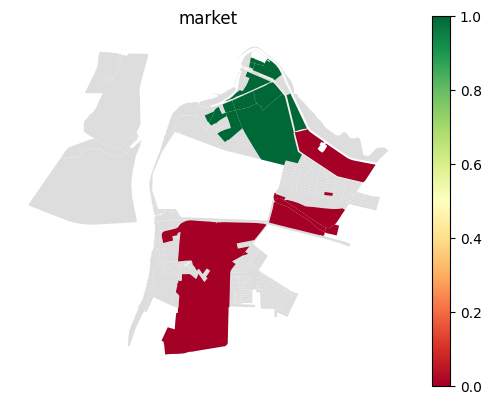

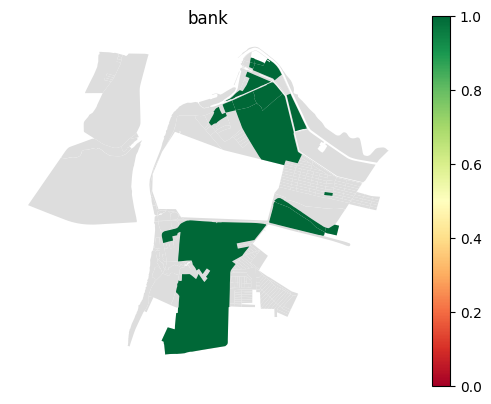

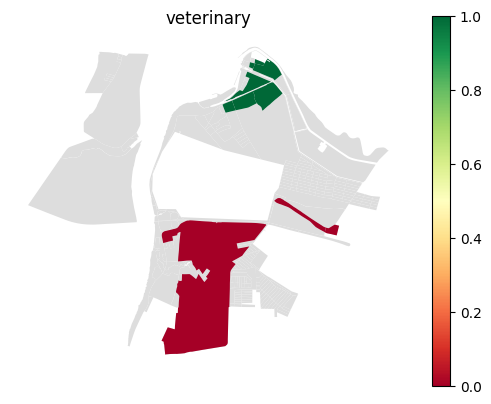

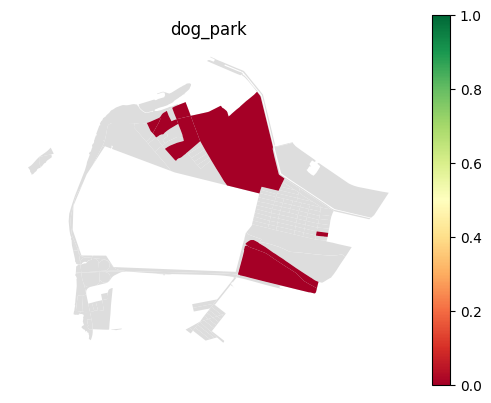

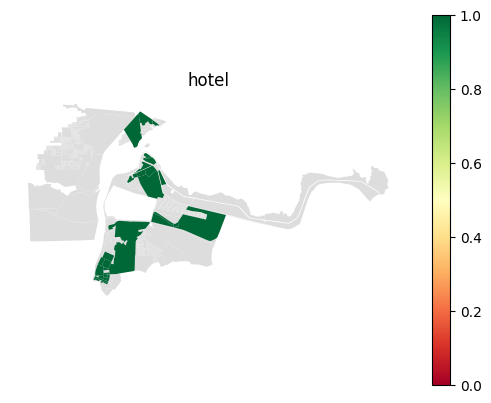

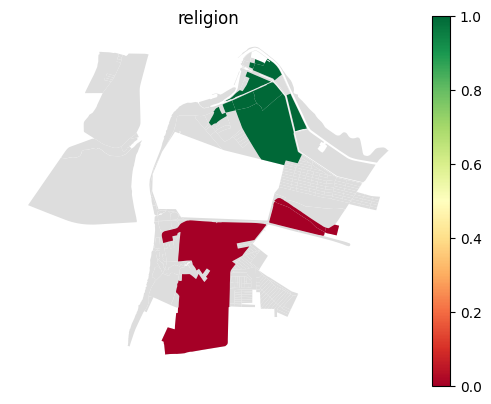

In [32]:
for st_name, prov_gdf in provisions_gdfs.items():
    if prov_gdf is None:
        continue
    ax = prov_gdf.plot(color='#ddd')
    prov_gdf.plot(ax=ax, column='provision_strong', legend=True, vmin=0, vmax=1, cmap='RdYlGn')
    ax.set_axis_off()
    ax.set_title(st_name) 